# Playtesting Notebook


## GNN

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
import sys, os, time
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [3]:
# tf.compat.v1.enable_eager_execution(
#     config=None, device_policy=None, execution_mode=None
# )

In [4]:
import tensorflow as tf

class Mlp(object):
    def __init__(
        self,
        layer_sizes,
        output_size = None,
        activations = None,
        output_activation = None,
        use_bias = True,
        kernel_initializer = None,
        bias_initializer = tf.zeros_initializer(),
        kernel_regularizer = None,
        bias_regularizer = None,
        activity_regularizer = None,
        kernel_constraint = None,
        bias_constraint = None,
        trainable = True,
        name = None,
        name_internal_layers = True
    ):
        """Stacks len(layer_sizes) dense layers on top of each other, with an additional layer with output_size neurons, if specified."""
        self.layers = []
        internal_name = None
        # If object isn't a list, assume it is a single value that will be repeated for all values
        if not isinstance( activations, list ):
            activations = [ activations for _ in layer_sizes ]
        #end if
        # If there is one specifically for the output, add it to the list of layers to be built
        if output_size is not None:
            layer_sizes = layer_sizes + [output_size]
            activations = activations + [output_activation]
        #end if
        for i, params in enumerate( zip( layer_sizes, activations ) ):
            size, activation = params
            if name_internal_layers:
                internal_name = name + "_MLP_layer_{}".format( i + 1 )
            #end if
            new_layer = tf.layers.Dense(
                size,
                activation = activation,
                use_bias = use_bias,
                kernel_initializer = kernel_initializer,
                bias_initializer = bias_initializer,
                kernel_regularizer = kernel_regularizer,
                bias_regularizer = bias_regularizer,
                activity_regularizer = activity_regularizer,
                kernel_constraint = kernel_constraint,
                bias_constraint = bias_constraint,
                trainable = trainable,
                name = internal_name
            )
            self.layers.append( new_layer )
        #end for
    #end __init__
    
    def __call__( self, inputs, *args, **kwargs ):
        outputs = [ inputs ]
        for layer in self.layers:
            outputs.append( layer( outputs[-1] ) )
        #end for
        return outputs[-1]
    #end __call__
#end Mlp

In [5]:
import tensorflow as tf
class TGN(object):
    def __init__(
        self,
        var,
        mat,
        msg,
        loop,
        MLP_depth = 3,
        MLP_weight_initializer = tf.contrib.layers.xavier_initializer,
        MLP_bias_initializer = tf.zeros_initializer,
        RNN_cell = tf.contrib.rnn.LayerNormBasicLSTMCell,
        Cell_activation = tf.nn.relu,
        Msg_activation = tf.nn.relu,
        Msg_last_activation = None,
        float_dtype = tf.float32,
        name = 'TGN'
    ):
        """
        Receives three dictionaries: var, mat and msg.

        ○ var is a dictionary from variable names to embedding sizes.
            That is: an entry var["V1"] = 10 means that the variable "V1" will have an embedding size of 10.
        
        ○ mat is a dictionary from matrix names to variable pairs.
            That is: an entry mat["M"] = ("V1","V2") means that the matrix "M" can be used to mask messages from "V1" to "V2".
        
        ○ msg is a dictionary from function names to variable pairs.
            That is: an entry msg["cast"] = ("V1","V2") means that one can apply "cast" to convert messages from "V1" to "V2".
        
        ○ loop is a dictionary from variable names to lists of dictionaries:
            {
                "mat": the matrix name which will be used,
                "transpose?": if true then the matrix M will be transposed,
                "fun": transfer function (python function built using tensorflow operations,
                "msg": message name,
                "var": variable name
            }
            If "mat" is None, it will be the identity matrix,
            If "transpose?" is None, it will default to false,
            if "fun" is None, no function will be applied,
            If "msg" is false, no message conversion function will be applied,
            If "var" is false, then [1] will be supplied as a surrogate.
            
            That is: an entry loop["V2"] = [ {"mat":None,"fun":f,"var":"V2"}, {"mat":"M","transpose?":true,"msg":"cast","var":"V1"} ] enforces the following update rule for every timestep:
                V2 ← tf.append( [ f(V2), Mᵀ × cast(V1) ] )
        """
        self.var, self.mat, self.msg, self.loop, self.name = var, mat, msg, loop, name

        self.MLP_depth = MLP_depth
        self.MLP_weight_initializer = MLP_weight_initializer
        self.MLP_bias_initializer = MLP_bias_initializer
        self.RNN_cell = RNN_cell
        self.Cell_activation = Cell_activation
        self.Msg_activation = Msg_activation
        self.Msg_last_activation    = Msg_last_activation 
        self.float_dtype = float_dtype
        
        # Check model for inconsistencies
        self.check_model()
        
        # Initialize the parameters
        with tf.variable_scope(self.name):
            with tf.variable_scope('parameters'):
                self._init_parameters()
            #end parameter scope
        #end TGN scope
    #end __init__

    def check_model(self):
        # Procedure to check model for inconsistencies
        for v in self.var:
            if v not in self.loop:
                raise Warning('Variable {v} is not updated anywhere! Consider removing it from the model'.format(v=v))
            #end if
        #end for

        for v in self.loop:
            if v not in self.var:
                raise Exception('Updating variable {v}, which has not been declared!'.format(v=v))
            #end if
        #end for

        for mat, (v1,v2) in self.mat.items():
            if v1 not in self.var:
                raise Exception('Matrix {mat} definition depends on undeclared variable {v}'.format(mat=mat, v=v1))
            #end if
            if v2 not in self.var and type(v2) is not int:
                raise Exception('Matrix {mat} definition depends on undeclared variable {v}'.format(mat=mat, v=v2))
            #end if
        #end for

        for msg, (v1,v2) in self.msg.items():
            if v1 not in self.var:
                raise Exception('Message {msg} maps from undeclared variable {v}'.format(msg=msg, v=v1))
            #end if
            if v2 not in self.var:
                raise Exception('Message {msg} maps to undeclared variable {v}'.format(msg=msg, v=v2))
            #end if
        #end for
    #end check_model

    def _init_parameters(self):
        # Init LSTM cells
        self._RNN_cells = {
            v: self.RNN_cell(
             d,
             activation = self.Cell_activation
            ) for (v,d) in self.var.items()
        }
        # Init message-computing MLPs
        self._msg_MLPs = {
            msg: Mlp(
                layer_sizes                    = [ self.var[vin] for _ in range( self.MLP_depth ) ],
                output_size                    = self.var[vout],
                activations                    = [ self.Msg_activation for _ in range( self.MLP_depth ) ],
                output_activation        = self.Msg_last_activation,
                kernel_initializer     = self.MLP_weight_initializer(),
                bias_initializer         = self.MLP_weight_initializer(),
                name                                 = msg,
                name_internal_layers = True
            ) for msg, (vin,vout) in self.msg.items()
        }
    #end _init_parameters

    def __call__( self, adjacency_matrices, initial_embeddings, time_steps, LSTM_initial_states = {} ):
        with tf.variable_scope(self.name):
            with tf.variable_scope( "assertions" ):
                assertions = self.check_run( adjacency_matrices, initial_embeddings, time_steps, LSTM_initial_states )
            #end assertion variable scope
            with tf.control_dependencies( assertions ):
                states = {}
                for v, init in initial_embeddings.items():
                    h0 = init
                    c0 = tf.zeros_like(h0, dtype=self.float_dtype) if v not in LSTM_initial_states else LSTM_initial_states[v]
                    states[v] = tf.contrib.rnn.LSTMStateTuple(h=h0, c=c0)
                #end
                
                # Build while loop body function
                def while_body( t, states ):
                    new_states = {}
                    for v in self.var:
                        inputs = []
                        for update in self.loop[v]:
                            if 'var' in update:
                                y = states[update['var']].h
                                if 'fun' in update:
                                    y = update['fun'](y)
                                #end if
                                if 'msg' in update:
                                    y = self._msg_MLPs[update['msg']](y)
                                #end if
                                if 'mat' in update:
                                    y = tf.matmul(
                                        adjacency_matrices[update['mat']],
                                        y,
                                        adjoint_a = update['transpose?'] if 'transpose?' in update else False
                                    )
                                #end if
                                inputs.append( y )
                            else:
                                inputs.append( adjacency_matrices[update['mat']] )
                            #end if var in update
                        #end for update in loop
                        inputs = tf.concat( inputs, axis = 1 )
                        with tf.variable_scope( '{v}_cell'.format( v = v ) ):
                            _, new_states[v] = self._RNN_cells[v]( inputs = inputs, state = states[v] )
                        #end cell scope
                    #end for v in var
                    return (t+1), new_states
                #end while_body
                
                _, last_states = tf.while_loop(
                    lambda t, states: tf.less( t, time_steps ),
                    while_body,
                    [0,states]
                )
            #end assertions
        #end Graph scope
#         print(last_states)
        return last_states
    #end __call__

    def check_run( self, adjacency_matrices, initial_embeddings, time_steps, LSTM_initial_states ):
        assertions = []
        # Procedure to check model for inconsistencies
        num_vars = {}
        for v, d in self.var.items():
            init_shape = tf.shape( initial_embeddings[v] )
            num_vars[v] = init_shape[0]
            assertions.append(
                tf.assert_equal(
                    init_shape[1],
                    d,
                    data = [ init_shape[1] ],
                    message = "Initial embedding of variable {v} doesn't have the same dimensionality {d} as declared".format(
                        v = v,
                        d = d
                    )
                )
            )
            if v in LSTM_initial_states:
                lstm_init_shape = tf.shape( LSTM_initial_states[v] )
                assertions.append(
                    tf.assert_equal(
                        lstm_init_shape[1],
                        d,
                        data = [ lstm_init_shape[1] ],
                        message = "Initial hidden state of variable {v}'s LSTM doesn't have the same dimensionality {d} as declared".format(
                            v = v,
                            d = d
                        )
                    )
                )
                    
                assertions.append(
                    tf.assert_equal(
                        lstm_init_shape,
                        init_shape,
                        data = [ init_shape, lstm_init_shape ],
                        message = "Initial embeddings of variable {v} don't have the same shape as the its LSTM's initial hidden state".format(
                            v = v,
                            d = d
                        )
                    )
                )
            #end if
        #end for v

        for mat, (v1,v2) in self.mat.items():
            mat_shape = tf.shape( adjacency_matrices[mat] )
            assertions.append(
                tf.assert_equal(
                    mat_shape[0],
                    num_vars[v1],
                    data = [ mat_shape[0], num_vars[v1] ],
                    message = "Matrix {m} doesn't have the same number of nodes as the initial embeddings of its variable {v}".format(
                        v = v1,
                        m = mat
                    )
                )
            )
            if type(v2) is int:
                assertions.append(
                    tf.assert_equal(
                        mat_shape[1],
                        v2,
                        data = [ mat_shape[1], v2 ],
                        message = "Matrix {m} doesn't have the same dimensionality {d} on the second variable as declared".format(
                            m = mat,
                            d = v2
                        )
                    )
                )
            else:
                assertions.append(
                    tf.assert_equal(
                        mat_shape[1],
                        num_vars[v2],
                        data = [ mat_shape[1], num_vars[v2] ],
                        message = "Matrix {m} doesn't have the same number of nodes as the initial embeddings of its variable {v}".format(
                            v = v2,
                            m = mat
                        )
                    )
                )
            #end if-else
        #end for mat, (v1,v2)
        return assertions
    #end check_run
#end TGN

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [ ]:
def build_neurosat(d):
    print("start of neurosat")

    # Hyperparameters
    learning_rate = 2e-5
    parameter_l2norm_scaling = 1e-10
    global_norm_gradient_clipping_ratio = 0.65

    # Define placeholder for satisfiability statuses (one per problem)
    instance_SAT = tf.placeholder( tf.float32, [ None ], name = "instance_SAT" )
    time_steps = tf.placeholder(tf.int32, shape=(), name='time_steps')
    matrix_placeholder = tf.placeholder( tf.float32, [ None, None ], name = "M" )
    num_vars_on_instance = tf.placeholder( tf.int32, [ None ], name = "instance_n" )

    # Literals
    s = tf.shape( matrix_placeholder )
    l = s[0]
    m = s[1]
    n = tf.floordiv( l, tf.constant( 2 ) )
    # Compute number of problems
    p = tf.shape( instance_SAT )[0]
    print("start 2")
    # Define INV, a tf function to exchange positive and negative literal embeddings
    def INV(Lh):
        l = tf.shape(Lh)[0]
        n = tf.div(l,tf.constant(2))
        # Send messages from negated literals to positive ones, and vice-versa
        Lh_pos = tf.gather( Lh, tf.range( tf.constant( 0 ), n ) )
        Lh_neg = tf.gather( Lh, tf.range( n, l ) )
        Lh_inverted = tf.concat( [ Lh_neg, Lh_pos ], axis = 0 )
        return Lh_inverted
    #end
    
    var = { "L": d, "C": d }
    s = tf.shape( matrix_placeholder )
    num_vars = { "L": l, "C": m }
    print("start 3")
    initial_embeddings = { v:tf.get_variable(initializer=tf.random_normal((1,d)), dtype=tf.float32, name='{v}_init'.format(v=v)) for (v,d) in var.items() }
    tiled_and_normalized_initial_embeddings = {
        v: tf.tile(
            tf.div(
                init,
                tf.sqrt( tf.cast( var[v], tf.float32 ) )
            ),
            [ num_vars[v], 1 ]
        ) for v, init in initial_embeddings.items()
    }
    print("start 3")
    # Define Typed Graph Network
    gnn = TGN(
        var,
        {
            "M": ("L","C")
        },
        {
            "Lmsg": ("L","C"),
            "Cmsg": ("C","L")
        },
        {
            "L": [
                {
                    "fun": INV,
                    "var": "L"
                },
                {
                    "mat": "M",
                    "msg": "Cmsg",
                    "var": "C"
                }
            ],
            "C": [
                {
                    "mat": "M",
                    "transpose?": True,
                    "msg": "Lmsg",
                    "var": "L"
                }
            ]
        },
        name="NeuroSAT"
    )
    print("start 4")
    # Define L_vote
    L_vote_MLP = Mlp(
        layer_sizes = [ d for _ in range(3) ],
        activations = [ tf.nn.relu for _ in range(3) ],
        output_size = 1,
        name = "L_vote",
        name_internal_layers = True,
        kernel_initializer = tf.contrib.layers.xavier_initializer(),
        bias_initializer = tf.zeros_initializer()
    )

    # Get the last embeddings
    print("start 5")
    L_n = gnn(
        { "M": matrix_placeholder },
        tiled_and_normalized_initial_embeddings,
        time_steps
    )["L"].h
    
    with tf.Session() as sess:
        sess.run(L_n)
    print("L_n {}".format(L_n.get_shape()))
    print("L_n {}".format(L_n))
    
    L_vote = L_vote_MLP( L_n )
    print("start 6")
    # Reorganize votes' result to obtain a prediction for each problem instance
    def _vote_while_cond(i, p, n_acc, n, n_var_list, predicted_sat, L_vote):
        return tf.less( i, p )
    #end _vote_while_cond

    def _vote_while_body(i, p, n_acc, n, n_var_list, predicted_SAT, L_vote):
        # Helper for the amount of variables in this problem
        i_n = n_var_list[i]
        # Gather the positive and negative literals for that problem
        pos_lits = tf.gather( L_vote, tf.range( n_acc, tf.add( n_acc, i_n ) ) )
        neg_lits = tf.gather( L_vote, tf.range( tf.add( n, n_acc ), tf.add( n, tf.add( n_acc, i_n ) ) ) )
        # Concatenate positive and negative literals and average their vote values
        problem_predicted_SAT = tf.reduce_mean( tf.concat( [pos_lits, neg_lits], axis = 1 ) )
        # Update TensorArray
        predicted_SAT = predicted_SAT.write( i, problem_predicted_SAT )
        return tf.add( i, tf.constant( 1 ) ), p, tf.add( n_acc, i_n ), n, n_var_list, predicted_SAT, L_vote
    #end _vote_while_body
    print("start 7")
    predicted_SAT = tf.TensorArray( size = p, dtype = tf.float32 )
    _, _, _, _, _, predicted_SAT, _ = tf.while_loop(
        _vote_while_cond,
        _vote_while_body,
        [ tf.constant( 0, dtype = tf.int32 ), p, tf.constant( 0, dtype = tf.int32 ), n, num_vars_on_instance, predicted_SAT, L_vote ]
    )
    predicted_SAT = predicted_SAT.stack()
    print("start 8")
    # Define loss, accuracy
    predict_costs = tf.nn.sigmoid_cross_entropy_with_logits( labels = instance_SAT, logits = predicted_SAT )
    predict_cost = tf.reduce_mean( predict_costs )
    vars_cost = tf.zeros([])
    tvars = tf.trainable_variables()
    for var in tvars:
        vars_cost = tf.add( vars_cost, tf.nn.l2_loss( var ) )
    #end for
    loss = tf.add( predict_cost, tf.multiply( vars_cost, parameter_l2norm_scaling ) )
    optimizer = tf.train.AdamOptimizer( name = "Adam", learning_rate = learning_rate )
    grads, _ = tf.clip_by_global_norm( tf.gradients( loss, tvars ), global_norm_gradient_clipping_ratio )
    train_step = optimizer.apply_gradients( zip( grads, tvars ) )
    
    accuracy = tf.reduce_mean(
        tf.cast(
            tf.equal(
                tf.cast( instance_SAT, tf.bool ),
                tf.cast( tf.round( tf.nn.sigmoid( predicted_SAT ) ), tf.bool )
            )
            , tf.float32
        )
    )
    print("start 9")
    # Define neurosat dictionary
    neurosat = {}
    neurosat["M"]                                        = matrix_placeholder
    neurosat["time_steps"]                     = time_steps
    neurosat["gnn"]                                    = gnn
    neurosat["instance_SAT"]                 = instance_SAT
    neurosat["predicted_SAT"]                = predicted_SAT
    neurosat["num_vars_on_instance"] = num_vars_on_instance
    neurosat["loss"]                                 = loss
    neurosat["accuracy"]                         = accuracy
    neurosat["train_step"]                     = train_step

    return neurosat
#end build_neurosat

In [7]:
build_neurosat(128)

start of neurosat
start 2
start 3
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
start 3
start 4
start 5


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument: You must feed a value for placeholder tensor 'time_steps' with dtype int32
	 [[node time_steps (defined at /home/ubuntu/anaconda3/envs/tensorflow_p37/gpu_cuda10.0/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1748) ]]
  (1) Invalid argument: You must feed a value for placeholder tensor 'time_steps' with dtype int32
	 [[node time_steps (defined at /home/ubuntu/anaconda3/envs/tensorflow_p37/gpu_cuda10.0/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1748) ]]
	 [[NeuroSAT_1/while/Exit_4/_15]]
0 successful operations.
0 derived errors ignored.

Original stack trace for 'time_steps':
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 612, in start
    self.io_loop.start()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
    self._run_once()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
    handle._run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/tornado/ioloop.py", line 688, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/tornado/gen.py", line 814, in inner
    self.ctx_run(self.run)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/tornado/gen.py", line 775, in run
    yielded = self.gen.send(value)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 358, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 538, in execute_request
    user_expressions, allow_stdin,
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 302, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 539, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2887, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2932, in _run_cell
    return runner(coro)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3156, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3347, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3427, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-2c50b2ff01db>", line 1, in <module>
    build_neurosat(128)
  File "<ipython-input-6-adf91b93de31>", line 11, in build_neurosat
    time_steps = tf.placeholder(tf.int32, shape=(), name='time_steps')
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/gpu_cuda10.0/lib/python3.7/site-packages/tensorflow_core/python/ops/array_ops.py", line 2619, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/gpu_cuda10.0/lib/python3.7/site-packages/tensorflow_core/python/ops/gen_array_ops.py", line 6669, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/gpu_cuda10.0/lib/python3.7/site-packages/tensorflow_core/python/framework/op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/gpu_cuda10.0/lib/python3.7/site-packages/tensorflow_core/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/gpu_cuda10.0/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/gpu_cuda10.0/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/gpu_cuda10.0/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()


In [7]:
d = 128
batch_size = 64
solver = build_neurosat( d )

# Create model saver
saver = tf.train.Saver()

with tf.Session() as sess:

    # Initialize global variables
    sess.run( tf.global_variables_initializer() )

    # Restore saved weights
    saver.restore(sess, "tmp/neurosat.ckpt")

    # Test SR distribution
    test_with(
        sess,
        solver,
        "./test-instances",
        "SR",
        time_steps = test_time_steps
    )
    # Test Phase Transition distribution
    test_with(
        sess,
        solver,
        "./critical-instances-40",
        "PT40",
        time_steps = test_time_steps
    )
    test_with(
        sess,
        solver,
        "./critical-instances-80",
        "PT80",
        time_steps = test_time_steps
    )

start of neurosat
start 2
start 3
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
start 3
start 4
start 5
L_n (?, 128)
L_n Tensor("NeuroSAT_1/while/Exit_4:0", shape=(?, 128), dtype=float32)
start 6
start 7
start 8
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/ubuntu/anaconda3/envs/tensorflow_p37/gpu_cuda10.0/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ubuntu/anaconda3/envs/tensorflow_p37/gpu_cuda10.0/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


start 9


NotFoundError: ./tmp; No such file or directory

# Environment setup

In [7]:
!pip -q install timm

In [8]:
from typing import Dict

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet50, resnet18, resnet34, resnet101
from tqdm import tqdm

import l5kit
from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path

import matplotlib.pyplot as plt

import os
import random
import time

import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'l5kit'

In [ ]:
import sys
import timm

In [ ]:
l5kit.__version__

In [ ]:
import torch
x1 = torch.ones((264,2)) #1-> batch
x2 = torch.zeros((100,2)) #2-> batch
l1 = [x1,x2]
l1_shapes = [x1.shape[0], x2.shape[0]]
nbrs_batch = torch.nn.utils.rnn.pad_sequence(tuple(l1), batch_first=True)

bleh_unpacked1 = torch.nn.utils.rnn.pad_sequence(tuple(l1), batch_first=True)

print(nbrs_batch.shape)
bleh1 = torch.nn.utils.rnn.pack_padded_sequence(nbrs_batch, l1_shapes, batch_first=True)

In [ ]:
x1 = torch.ones((264,2)) #1-> batch
x2 = torch.zeros((300,2)) #2-> batch
l1 = [x1,x2]
l1_shapes = [x1.shape[0], x2.shape[0]]
nbrs_batch = torch.nn.utils.rnn.pad_sequence(tuple(l1), batch_first=True)
bleh_unpacked2 = torch.nn.utils.rnn.pad_sequence(tuple(l1), batch_first=True)
print(nbrs_batch.shape)
bleh2 = torch.nn.utils.rnn.pack_padded_sequence(nbrs_batch, l1_shapes, batch_first=True, enforce_sorted=False)

In [23]:
torch.nn.utils.rnn.pack_sequence([bleh_unpacked1, bleh_unpacked2])

RuntimeError: The expanded size of the tensor (264) must match the existing size (300) at non-singleton dimension 1.  Target sizes: [2, 264, 2].  Tensor sizes: [2, 300, 2]

In [3]:
bleh[0][:, 0].shape

torch.Size([364])

In [6]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
set_seed(42)

## Configs

In [7]:
# --- Lyft configs ---
cfg = {
    'format_version': 4,
    'data_path': "lyft_dataset",
    'model_params': {
        'model_architecture': 'resnet34',
        'history_num_frames': 10,
        'history_step_size': 1,
        'history_delta_time': 0.1,
        'future_num_frames': 50,
        'future_step_size': 1,
        'future_delta_time': 0.1,
        'model_name': "model_resnet34_output",
        'lr': 1e-3,
        'train': False,
        'predict': True
    },

    'raster_params': {
        'raster_size': [224, 224],
        'pixel_size': [0.5, 0.5],
        'ego_center': [0.25, 0.5],
        'map_type': 'py_semantic',
        'satellite_map_key': 'aerial_map/aerial_map.png',
        'semantic_map_key': 'semantic_map/semantic_map.pb',
        'dataset_meta_key': 'meta.json',
        'filter_agents_threshold': 0.5
    },

    'train_data_loader': {
        'key': 'scenes/train.zarr',
        'batch_size': 16,
        'shuffle': True,
        'num_workers': 4
    },
    
    'test_data_loader': {
        'key': 'scenes/test.zarr',
        'batch_size': 32,
        'shuffle': False,
        'num_workers': 4
    },

    'train_params': {
        'max_num_steps': 101,
        'checkpoint_every_n_steps': 20,
    }
}

Couple of things to note:

 - **model_architecture:** you can put 'resnet18', 'resnet34' or 'resnet50'. For the pretrained model we use resnet18 so we need to use 'resnet18' in the config.
 - **weight_path:** path to the pretrained model. If you don't have a pretrained model and want to train from scratch, put **weight_path** = False. 
 - **model_name:** the name of the model that will be saved as output, this is only when **train**= True.
 - **train:** True if you want to continue to train the model. Unfortunately due to Kaggle memory constraint if **train**=True then you should put **predict** = False.
 - **predict:** True if you want to predict and submit to Kaggle. Unfortunately due to Kaggle memory constraint if you want to predict then you need  to put **train** = False.
 - **lr:** learning rate of the model, feel free to change as you see fit. In the future I also plan to implement learning rate decay. 
 - **raster_size:** specify the size of the image, the default is [224,224]. Increase **raster_size** can improve the score. However the training time will be significantly longer. 
 - **batch_size:** number of inputs for one forward pass, again one of the parameters to tune. 
 - **max_num_steps:** the number of iterations to train, i.e. number of epochs.
 - **checkpoint_every_n_steps:** the model will be saved at every n steps, again change this number as to how you want to keep track of the model.

## Load the train and test data

In [8]:
# set env variable for data
DIR_INPUT = cfg["data_path"]
os.environ["L5KIT_DATA_FOLDER"] = DIR_INPUT
dm = LocalDataManager(None)

In [9]:
# ===== INIT TRAIN DATASET============================================================
train_cfg = cfg["train_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()

#create mask 


train_dataset = AgentDataset(cfg, train_zarr, rasterizer)
train_dataloader = DataLoader(train_dataset, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"], 
                             num_workers=train_cfg["num_workers"])
print("==================================TRAIN DATA==================================")
print(train_dataset)

==================================TRAIN DATA==================================
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [10]:
# ===== INIT TRAIN DATASET============================================================
train_cfg = cfg["train_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()

#create mask 


train_dataset_ego = EgoDataset(cfg, train_zarr, rasterizer)


In [43]:
train_dataset[np.array([0,1,2,3])]

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [48]:
import time
st = time.time()
p = train_dataset[0]["history_positions"]
et = time.time()
print(et-st)

0.030867576599121094


In [41]:
train_dataset.get_scene_indices()

TypeError: '<' not supported between instances of 'list' and 'int'

In [11]:
x = next(iter(train_dataset))

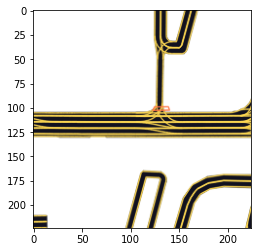

In [12]:
agent_idxs = range(0, len(train_dataset))
data = train_dataset[0]
img = data["image"]  # BEV input
translations = data["target_positions"]  # future translations for the agent
plt.imshow(img.transpose(1,2,0)[:,:,22:25])
plt.show()
#     print("Translations {}".format(translations))

In [13]:
frame_idx = 0
agent_indices = train_dataset.get_frame_indices(frame_idx)  # this function is slow, but there is a branch with an improved version
agents = [train_dataset[idx] for idx in agent_indices]
ego_info = train_dataset_ego[frame_idx]  # this is the ego for those agents

In [14]:
train_dataset.get_scene_indices(0) #agent dataset

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34])

In [15]:
agent_len = len(train_dataset)
ego_len = len(train_dataset_ego)

print("Agent len {}".format(agent_len))
print("Ego len {}".format(ego_len))
print("Ratio {}".format(agent_len/ego_len))

Agent len 22496709
Ego len 4039527
Ratio 5.569144357742874


## Testing Dataloader

In [16]:
x = next(iter(train_dataloader))

In [17]:
x.keys()

dict_keys(['image', 'target_positions', 'target_yaws', 'target_availabilities', 'history_positions', 'history_yaws', 'history_availabilities', 'world_to_image', 'raster_from_world', 'raster_from_agent', 'agent_from_world', 'world_from_agent', 'track_id', 'timestamp', 'centroid', 'yaw', 'extent'])

In [18]:
x["track_id"]

tensor([   1,    2,  424,    6, 1367,  771,   69,    3,   13,  254,    2,  639,
          60,  332,    7,    3])

In [29]:
import bisect, yaml
import zarr

In [32]:
z = zarr.open('lyft-motion-prediction-autonomous-vehicles/scenes/test.zarr')

In [31]:
agents_ij = z.frames["agent_index_interval"]

def get_scene(agent_id):
    frame_id = bisect.bisect_right(agents_ij[:, 0], agent_id)-1
    scene_id = bisect.bisect_right(frames_ij[:, 0], frame_id)-1
    
#     print(scene_id,frame_id,agent_id)
    
    scene = z.scenes[scene_id]
    frame = z.frames[frame_id]
    agent = z.agents[agent_id]
    return scene,(frame,frame_id+1),agent

def get_agent_data(agent_id):
    scene, (frame,frame_id), agent = get_scene(agent_id)
    X, X_light, _, _, le = dt.read_frames(
            scene=scene,
            start=frame_id-HBACKWARD,
            white_tracks=[agent["track_id"]],
            encoder=True
    )
    
    X_track_id = np.array([agent["track_id"]], dtype=np.int64)
    X_track = np.array([le.labels[agent["track_id"]]], dtype=np.int64)
    X_timestamp = np.array([frame["timestamp"]], dtype=np.int64)
    return X, X_light, X_track, X_track_id, X_timestamp

AttributeError: 

In [26]:
get_agent_data(1)

NameError: name 'agents_ij' is not defined

## Simple visualization

Let us visualize how an input to the model looks like.

In [13]:
def visualize_trajectory(dataset, index, title="target_positions movement with draw_trajectory"):
    data = dataset[index]
    im = data["image"].transpose(1, 2, 0)
    print(im.shape)
    im = dataset.rasterizer.to_rgb(im)
    target_positions_pixels = transform_points(data["target_positions"] + data["centroid"][:2], data["world_to_image"])
    draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, radius=1, yaws=data["target_yaws"])

    plt.title(title)
    plt.imshow(im[::-1])
    plt.show()

(224, 224, 25)


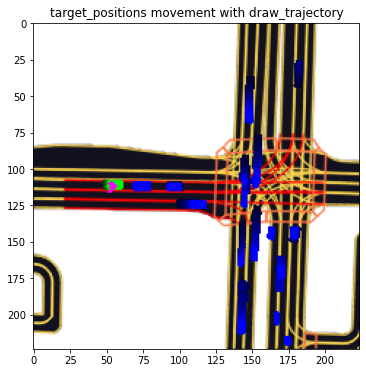

In [14]:
plt.figure(figsize = (8,6))
visualize_trajectory(train_dataset, index=90)